# Inductive biases and symmetries

**Group work:** It's time for group work! Form groups of 2 and work through the notebook together.

In the previous notebook, we saw that neural networks can be used to solve a large variety of tasks. The main reason for the verstility of neural networks is two-fold: 1. neural networks are universal function approximators, meaning they can learn any function from data; and 2. surprisingly many tasks can be approximated as input-output relationships, i.e. functions. For example, we saw that digit classification can be achieved by learning a probability density function, $p(y | x)$, where $x$ denotes the pixels in the image, and $y$ denotes the digit. In this notebook, we dive deeper into some of the challenges of learning functions from data -- challenges that are important to understand when modelling language with neural networks.

More specifically, we focus on two related aspects of training neural networks: 1. the ability of neural networks to learn efficiently from data; and 2. the ability of neural networks to generalise beyond the training data.

**Learning outcomes:**

1. An intuitive understanding of architectural choices for neural networks
2. The limitations of learning functions from data (especially for extrapolation!)
3. The value of prior knowledge for more efficient learning and better generalisation

Credit goes to https://medium.com/@bpoyeka1/building-simple-neural-networks-nn-cnn-using-pytorch-for-mnist-dataset-31e459d17788 for providing a starting point of this notebook.

In [2]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

## 1 The limitations of learning functions from data: using MNIST as an example

To begin this session, let us revisit the MNIST image classification challenge that we have worked on in the previous notebook. To classify images into one of 10 digits, we used a multi-layer perceptron to process images and predict the probability masses for the different class labels.

### Task 1: Run the cells below to repeat the training of the model from the last notebook

In [15]:
# Define model
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load Data
batch_size = 64
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Set up training
input_size = 784
num_classes = 10
learning_rate = 0.001
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Network
model = NN(input_size=input_size, num_classes=num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
# 1 epoch => Network has seen all the images in the dataset

    print(f'Epoch: {epoch}')

    for batch_idx, (data, targets) in enumerate(train_loader):

        data = data.to(device=device)
        targets = targets.to(device=device)

        data = data.reshape(data.shape[0], -1)  # Flatten
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # set all gradients to zero for each batch
        loss.backward()

        # gradient descent
        optimizer.step()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


Check that the model reaches the same accuracy as before (>95%).

In [16]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():  # dont compute gradients
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0],-1)

            scores = model(x)
            _, predictions = scores.max(1)

            # print(predictions)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100: .2f}')

    model.train()

print('Accuracy on training data:')
check_accuracy(train_loader, model)
print('Accuracy on test data:')
check_accuracy(test_loader, model)

Accuracy on training data:
Got 58419/60000 with accuracy  97.36
Accuracy on test data:
Got 9631/10000 with accuracy  96.31


So far, so good! The model achieves the same performance as before, as expected. However, at the moment, the image classification task is a little bit unrealistic, as all digits are located exactly at the center of each image. 

Let us therefore repeat the training of the neural network on data where the digits are not centered in the image, just to see whether performance of the neural network is sensitive to the translation.

### Task 2: Execute the below cell to visualise padded versions of the digit images

The below code pads images such that all digits are now located in the top right corner.

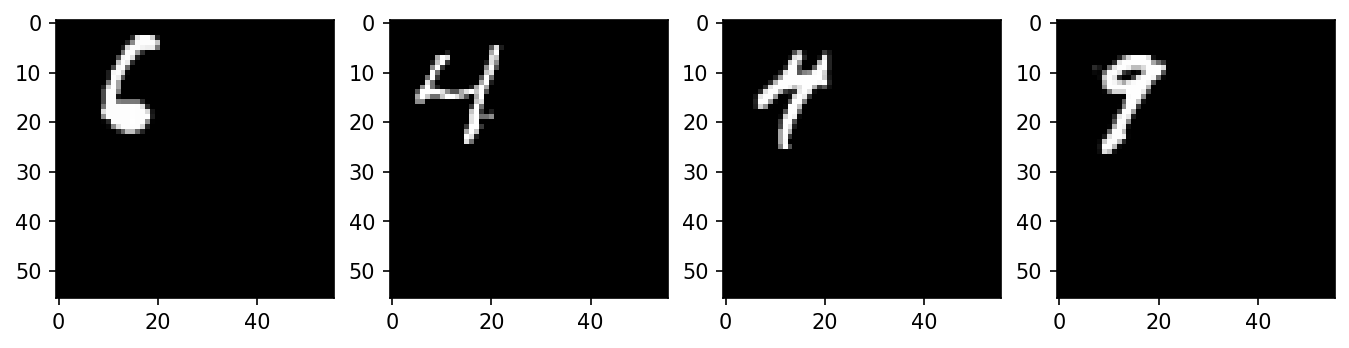

In [17]:
# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Padd images
n_batch, n_channels, n_width, n_height = images.shape
padded = torch.zeros(size=(n_batch, n_channels, n_width*2, n_height*2))
padded[:, :, :n_width, :n_height] = images

# Visualise images
# Create layout
fontsize = 14
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 4)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

for ida, ax in enumerate(axes):
    ax.imshow(padded[ida][0], cmap='gray')
plt.show()

### Task 3: Train the network on padded images
The cell below pads the images in the train and test datasets. Copy the training script from above and use the padded images to train a new neural network. Make amendments to the code as required. In particular, remember to:
1. multiply the input size by 4 because the images are now 4 times as big;
2.  use the padded_train_loader for the training.

In [18]:
class PaddedDataLoader:
    def __init__(self, dataloader, padding='top-left'):
         self.dataloader = dataloader
         self.padding = padding

    def __iter__(self):
        for images, labels in self.dataloader:
            # Padd images
            n_batch, n_channels, n_width, n_height = images.shape
            padded = torch.zeros(size=(n_batch, n_channels, n_width*2, n_height*2))
            if self.padding == 'top-left':
                padded[:, :, :n_width, :n_height] = images
            else:
                padded[:, :, -n_width:, -n_height:] = images

            yield padded, labels

padded_train_loader = PaddedDataLoader(train_loader)
padded_test_loader = PaddedDataLoader(test_loader, padding='other')

In [19]:
# TODO: Copy the relevant code from above and train the neural network again on the padded data.
# (Remember to:
#    1. multiply the input size by 4 because the images are now 4 times as big;
#    2. use the padded_train_loader for the training.

# Hyperparameters
input_size = 784 * 4
num_classes = 10
learning_rate = 0.001
num_epochs = 5

# Initialize Network
model = NN(input_size=input_size, num_classes=num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')

    for batch_idx, (data, targets) in enumerate(padded_train_loader):

        data = data.to(device=device)
        targets = targets.to(device=device)

        data = data.reshape(data.shape[0], -1)  # Flatten
        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


Evaluate the trained model on the padded datasets. You should achieve a similar accuracy on the training data as before (>95%).

In [20]:
print('Accuracy on training data:')
check_accuracy(padded_train_loader, model)
print('Accuracy on test data:')
check_accuracy(padded_test_loader, model)

Accuracy on training data:
Got 58444/60000 with accuracy  97.41
Accuracy on test data:
Got 947/10000 with accuracy  9.47


The accuracy on the test dataset is dramatically lower than before!

### Task 4: Discuss in your group why the performance on the test dataset is so much lower now

You might find it useful to visualise some images from the train dataset and some images from the test dataset using the code that we have used above.

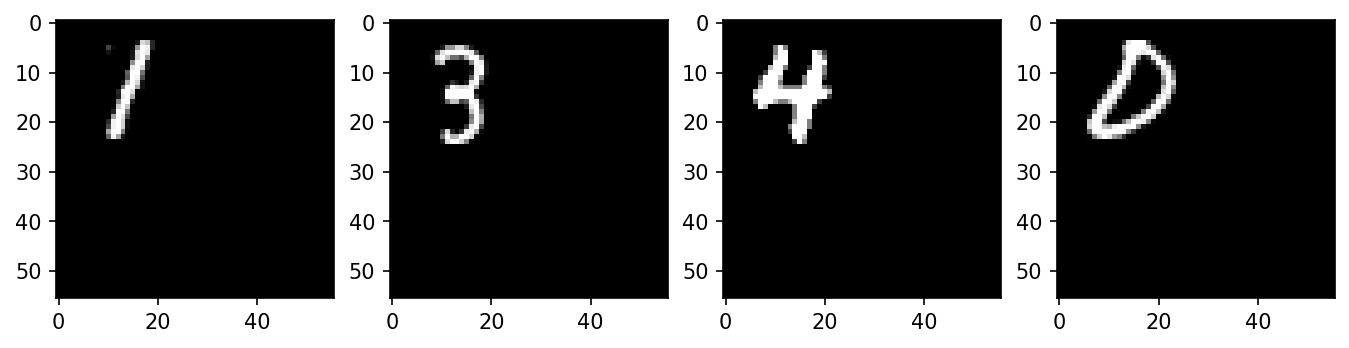

In [23]:
# TODO: Plot a few training images
# Get a batch of images and labels
images, labels = next(iter(padded_train_loader))

# Create layout
fontsize = 14
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 4)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

for ida, ax in enumerate(axes):
    ax.imshow(images[ida][0], cmap='gray')
plt.show()

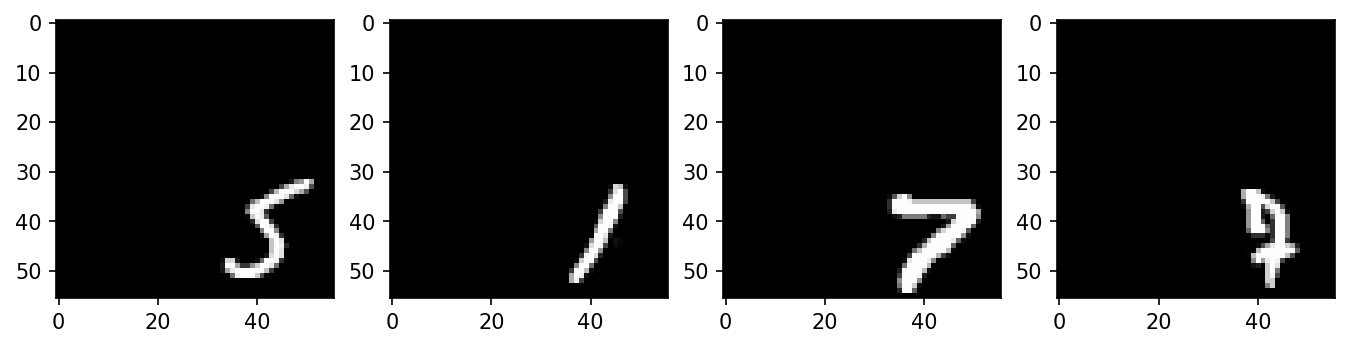

In [24]:
# TODO: Plot a few test images
# Get a batch of images and labels
images, labels = next(iter(padded_test_loader))

# Create layout
fontsize = 14
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 4)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

for ida, ax in enumerate(axes):
    ax.imshow(images[ida][0], cmap='gray')
plt.show()

Why does the network not work? exercise discussion..

While neural can approximate any function, we only train their achieve these approximations only locally. This means that neural networks can only 